- (c) Ken-ichi Fukui, 2025/01/03
-  MIT License

## ナイーブベイズ分類器によるゴルフプレイデータの識別とROC,AUCによる評価
- データweather.nominal.arffは本プログラムと同じフォルダ内に置いておく

In [1]:
%matplotlib inline
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.naive_bayes import CategoricalNB
import matplotlib.pyplot as plt

### arffデータの読み込み

In [2]:
f = open("weather.nominal.arff", "r", encoding="utf-8")
data, meta = arff.loadarff(f)
df_data= pd.DataFrame(data)
df_data

,outlook,temperature,humidity,windy,play
0,b'sunny',b'hot',b'high',b'FALSE',b'no'
1,b'sunny',b'hot',b'high',b'TRUE',b'no'
2,b'overcast',b'hot',b'high',b'FALSE',b'yes'
3,b'rainy',b'mild',b'high',b'FALSE',b'yes'
4,b'rainy',b'cool',b'normal',b'FALSE',b'yes'
5,b'rainy',b'cool',b'normal',b'TRUE',b'no'
6,b'overcast',b'cool',b'normal',b'TRUE',b'yes'
7,b'sunny',b'mild',b'high',b'FALSE',b'no'
8,b'sunny',b'cool',b'normal',b'FALSE',b'yes'
9,b'rainy',b'mild',b'normal',b'FALSE',b'yes'


### OrdinalEncoderを使ってラベル特徴を数値に変換
例えば，変数outlookの値{sunny, overcast, rainy}は，{0,1,2}に変換される

In [3]:
enc = OrdinalEncoder()
feature_encorded = enc.fit_transform(df_data.loc[:,['outlook','temperature', 'humidity', 'windy']])
class_encorded = np.ravel(enc.fit_transform(df_data.loc[:,['play']])) # np.ravel()で1次元化

feature_encorded, class_encorded

(array([[2., 1., 0., 0.],
        [2., 1., 0., 1.],
        [0., 1., 0., 0.],
        [1., 2., 0., 0.],
        [1., 0., 1., 0.],
        [1., 0., 1., 1.],
        [0., 0., 1., 1.],
        [2., 2., 0., 0.],
        [2., 0., 1., 0.],
        [1., 2., 1., 0.],
        [2., 2., 1., 1.],
        [0., 2., 0., 1.],
        [0., 1., 1., 0.],
        [1., 2., 0., 1.]]),
 array([0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.]))

### 1つ抜き交差検証（Leave-one-out cross-validation）
全N個のデータから1個を除いた(N-1)個を学習データとしてモデルを学習し，残りの1個でテストを行う．これをN回繰り返す．

In [4]:
y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_encorded):
    X_train, X_test = feature_encorded[train_index], feature_encorded[test_index]
    y_train, y_test = class_encorded[train_index], class_encorded[test_index]

    # =====================================================================
    # カテゴリカルナイーブベイズ（CategoricalNB）を使用する．
    # alpha(>0)はスムージングのパラメータ．
    # ただし，等価標本サイズmとの関係はalpha=m/n
    # http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes
    # fit_prior=Trueに指定すると学習データから事前確率を求める．
    # class_priorは，class_prior=[0.2,0.8]の形で事前確率を指定する．fit_prior=Falseのときに有効．
    clf = CategoricalNB(alpha=0.1, class_prior=[0.2,0.8], fit_prior=False)
    clf.fit(X_train,y_train)

    # =====================================================================
    # 学習データとテストデータに対する各クラスの事後確率を算出
    posterior_trn = clf.predict_proba(X_train)
    posterior_tst = clf.predict_proba(X_test)

    # テストデータの正解クラスと事後確率を出力
    print("True Label:", y_test)
    print("Posterior Probability:", posterior_tst)

    # 正解クラスと事後確率を保存
    y_train_post_list.extend(posterior_trn[:,[1]])
    y_train_list.extend(y_train)
    y_test_post_list.append(posterior_tst[0][1])
    y_test_list.extend(y_test)

True Label: [0.]
Posterior Probability: [[0.34640859 0.65359141]]
True Label: [0.]
Posterior Probability: [[0.66566663 0.33433337]]
True Label: [1.]
Posterior Probability: [[0.07018445 0.92981555]]
True Label: [1.]
Posterior Probability: [[0.45364246 0.54635754]]
True Label: [1.]
Posterior Probability: [[0.06622938 0.93377062]]
True Label: [0.]
Posterior Probability: [[7.12743854e-04 9.99287256e-01]]
True Label: [1.]
Posterior Probability: [[0.00813569 0.99186431]]
True Label: [0.]
Posterior Probability: [[0.21350719 0.78649281]]
True Label: [1.]
Posterior Probability: [[0.16658657 0.83341343]]
True Label: [1.]
Posterior Probability: [[0.08401965 0.91598035]]
True Label: [1.]
Posterior Probability: [[0.48098808 0.51901192]]
True Label: [1.]
Posterior Probability: [[0.08760911 0.91239089]]
True Label: [1.]
Posterior Probability: [[0.00826981 0.99173019]]
True Label: [0.]
Posterior Probability: [[0.26571144 0.73428856]]


### ROC曲線の描画とAUCの算出

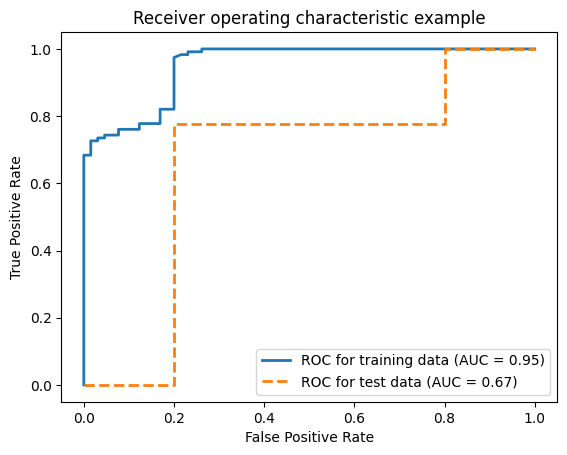

In [6]:
fpr_trn, tpr_trn, thresholds_trn = roc_curve(y_train_list, y_train_post_list)
roc_auc_trn = auc(fpr_trn, tpr_trn)
plt.plot(fpr_trn, tpr_trn, label='ROC for training data (AUC = %0.2f)' % roc_auc_trn, lw=2, linestyle="-")

fpr_tst, tpr_tst, thresholds_tst = roc_curve(y_test_list, y_test_post_list)
roc_auc_tst = auc(fpr_tst, tpr_tst)
plt.plot(fpr_tst, tpr_tst, label='ROC for test data (AUC = %0.2f)' % roc_auc_tst, lw=2, linestyle="--")

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()